# Grain Size Distribution - Height Correlation Function

Find relevant parameters describing the topography of sputtered Ruthenium thin films on Si substrate
How:
- Roughness RMS
- Fit exponential increase
- Take intersection between RMS asymptote and Fit

Output parameters:
- Roughness
- Correlation Length
- Alpha exponent

In [26]:
import os
import sys

import numpy as np

%matplotlib nbagg
%reload_ext autoreload
%autoreload 2
%aimport AFM_lib

import matplotlib
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

from matplotlib import cm
from skimage import data, img_as_float, filters

from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter

import cv2
import plotly.graph_objects as go

In [27]:
debug = True #or 'False' when you do not want to debug

path = "/Users/sfiligoj/Desktop/Thesis/Data Analysis/AFM/SSP"
os.chdir(path)
#files = ['Ru_H_NotA_original.txt','Ru_H_NotA_original_thres.txt']
filess = os.listdir()
filess = [f for f in filess if f.endswith('txt')]
z_score = 3.5

In [28]:
#open dictionary of Scan Size values:
with open('ScanSizes.json', 'r') as f:
    ScanSize_dict = json.loads(f.read())

In [67]:
fig = go.Figure()
data = dict.fromkeys(filess)
colors=['#000000','#EE7733', '#0077BB', '#33BBEE', '#EE3377', '#CC3311','#009988', '#BBBBBB']

for i,file in enumerate(filess[39:]):
    
    if '*' in file:
        continue  
    if 'um' in file:
        continue  
#     if 'nm' in file:
#         continue  
    if '_H_' in file:
        continue
        density = 'High'
        color = colors[2]
        if 'asdep' in file:
            temperature = 'as-deposited'
        else:
#             continue
            temperature = temperature = file[5:9]  
    if '_LH_' in file:
#         continue
        density = 'Low-High'
        color = colors[4]
        if '700C' in file:
            temperature = '700C'
        else:
            continue
            temperature = temperature = file[5:9]          
    if '_L_' in file:
        continue
        density = 'Low'
        color = colors[6]
        if '700C' in file:
            temperature = '700C'
        else:
            continue
            temperature = temperature = file[6:10]
    if '_Si_' in file:
        continue
        density = 'Si(100)'
        color = colors[0]
        if 'Bare' in file:
            temperature = 'substrate'
            
    print(i)
    
            
    data[file] = {}
    
    filesize = os.path.getsize(file)     #to differentiate between 512x512 px or 1024x1024 px img
    Pix_width = int(np.sqrt(filesize/32))
    Pix_height = Pix_width
 
    data[file]['orig'] = np.genfromtxt(file, skip_header=1).reshape((Pix_width,Pix_height))
    
    if Pix_width == 1024:
        print(f"Resampling file: {file}")
        data[file]['orig'] = cv2.resize(data[file]['orig'], dsize=(512,512),interpolation=cv2.INTER_LINEAR)
    if Pix_width == 256:
        print(f"Resampling file: {file}")
        data[file]['orig'] = cv2.resize(data[file]['orig'], dsize=(512,512),interpolation=cv2.INTER_LINEAR)
        
    data[file]['img'] = AFM_lib.remove_outliers(data[file]['orig'],threshold=z_score)   #was 3
        
    N_Pixel = data[file]['img'].shape[1] 
    ScanSize = ScanSize_dict[file]                      # nm
    StepSize = ScanSize/N_Pixel                         # nm/px   
    Xdelta = np.linspace(StepSize, ScanSize, num=N_Pixel)

    rows, cols = data[file]['img'].shape
    midrows = rows // 2
    midcols = cols // 2
    
    quadrant1 = data[file]['img'][: midrows ,: midcols ]
    quadrant2 = data[file]['img'][: midrows , midcols :]
    quadrant3 = data[file]['img'][ midrows :,: midcols ]
    quadrant4 = data[file]['img'][ midrows :, midcols :]
    
    quadrants = [quadrant1, quadrant2, quadrant3, quadrant4]
    
    for j,quad in enumerate(quadrants):
        
        print(f'running file:{file}, quadrant {j}')
        
        # ***    Calculate theoretical asymptotic value of the Height difference correlation: 2w^2   ***
    
        HeightSq = (quad)**2                        
        if False: print(f'HeightSq shape = {HeightSq.shape}') #  (should be 512x512)
        RMS_sq = np.mean(HeightSq)               #   RMS^2 = w^2 - also called Interface Width
        if False: print(f'RMS squared = {RMS_sq}')            #  (should be a scalar)
        RMS = np.sqrt(RMS_sq)


        #error on the measurements:
    #     error_sq = np.sort(sum((np.sqrt(HeightSq) - RMS)**2)/(len(HeightSq)-1))

        # ***    Calculate Height-Height correlation function:   ***

        HHcorr = np.zeros(N_Pixel, dtype='float')
        autocorr = np.zeros(N_Pixel, dtype='float')

        for px_dist in range(0, N_Pixel):
            shifted_data = quad[:,px_dist+1:].astype(float)
            data_section = quad[:,:-px_dist-1].astype(float)
            if False:
                print(f'shifted data= {shifted_data.shape}')
                print(f'sectioned data= {data_section.shape}')
            difference = (data_section-shifted_data)**2
            product = (data_section*shifted_data)
            HHcorr[px_dist] = np.mean(difference)
            autocorr[px_dist]= 2*np.mean(product)

        # ***    Fit the data:   ***

        # consider the following number of pixels for the fit:
    #   CutoffPointPLaw = int(np.argwhere(HHcorr>=2*RMS_sq)[0])
        CutoffPointPLaw = int(np.argwhere(Xdelta>=10)[0])


        a0=0
        # weights for the fit, used for Method 1
        y_err1 = 1/(np.arange(1,CutoffPointPLaw+1))**2
        # For this Method, we define:
        y_err2 = np.sqrt(HHcorr[:CutoffPointPLaw])
        y_err3 = np.arange(a0,CutoffPointPLaw+a0)**2
        weights = np.exp(y_err3)


        # ***    Model for describing power law (on log scale):

        Model = lambda x, a, alpha: a*x**(2*alpha)


        # ***    Fit data using Model

        popt, pcov = curve_fit(Model, Xdelta[a0:CutoffPointPLaw+a0], HHcorr[a0:CutoffPointPLaw+a0], 
                               sigma = weights)


        # ***    Extracting the correlation length   ***

        #*popt= a,alpha
        a = popt[0]                                         # primo parametro dipendente
        alpha = popt[1]                                     # secondo paramtero dipendente

        # Equating a*(x**alpha)= 2*RMS_sq you extract x, the correlation length
        CorrLength= (1/a *(2*RMS_sq))**(1/(2*alpha))

        
        label = f"{density}{file[-7:-4]}_Q{j}"
        # ***    Plot and save results:
        fig.add_trace(
            go.Scatter(
                x = Xdelta[:500], 
                y = HHcorr[:500],
                mode = 'lines+markers',
                name = label,
                opacity = 0.8,
                line = dict(
                color = color)))
        
        fig.update_layout(title={'text': f'Average HH-correlation function for Ru annealed at {temperature}', 
                                'xanchor':'center', 'yanchor': 'top', 'y':0.9,  'x':0.5},
                              xaxis=dict(title='Distance, L (nm)', ticks="inside",
                                      range=[np.log10(1.8),np.log10(500)],
                                      tickmode = "linear",
                                      tick0 = np.log10(1),
                                      dtick = np.log10(5),
        #                               linewidth=1, linecolor='black', mirror=True
                                     ),
                               yaxis=dict(title='HHcorr (nm²)', ticks="inside",
        #                               range=[np.log10(min(AvHHcorr[dens]['20']['value']*0.8)),
        #                                      np.log10((max(AvHHcorr['L']['25']['value']*1.3)))],
                                      tickmode = "linear",
                                      tick0 = np.log10(1),
                                      dtick = 'L0.1',
        #                               linewidth=1, linecolor='black', mirror=True
                                     ),
        #                    template ="plotly_white",
                           width=750, height=600
                              )

    fig.update_xaxes(type="log")
    fig.update_yaxes(type="log")

1
Resampling file: Ru_LH_700C_500nm_FLAT.007.txt
running file:Ru_LH_700C_500nm_FLAT.007.txt, quadrant 0
running file:Ru_LH_700C_500nm_FLAT.007.txt, quadrant 1
running file:Ru_LH_700C_500nm_FLAT.007.txt, quadrant 2
running file:Ru_LH_700C_500nm_FLAT.007.txt, quadrant 3
2
Resampling file: Ru_LH_700C_500nm_FLAT.006.txt
running file:Ru_LH_700C_500nm_FLAT.006.txt, quadrant 0
running file:Ru_LH_700C_500nm_FLAT.006.txt, quadrant 1
running file:Ru_LH_700C_500nm_FLAT.006.txt, quadrant 2
running file:Ru_LH_700C_500nm_FLAT.006.txt, quadrant 3
5
running file:Ru_LH_700C_500nm_FLAT.010.txt, quadrant 0
running file:Ru_LH_700C_500nm_FLAT.010.txt, quadrant 1
running file:Ru_LH_700C_500nm_FLAT.010.txt, quadrant 2
running file:Ru_LH_700C_500nm_FLAT.010.txt, quadrant 3
9
Resampling file: Ru_LH_700C_500nm_FLAT.005.txt
running file:Ru_LH_700C_500nm_FLAT.005.txt, quadrant 0
running file:Ru_LH_700C_500nm_FLAT.005.txt, quadrant 1
running file:Ru_LH_700C_500nm_FLAT.005.txt, quadrant 2
running file:Ru_LH_700C_50

In [68]:
fig.show()

In [60]:
fig.write_image("LH_600C_FILE013_quadrants.svg")
fig.write_image("LH_600C_FILE013_quadrants.png")

running file:Ru_H_800C_FLAT.010.txt, quadrant 0
256
0.8851119217533552


<IPython.core.display.Javascript object>


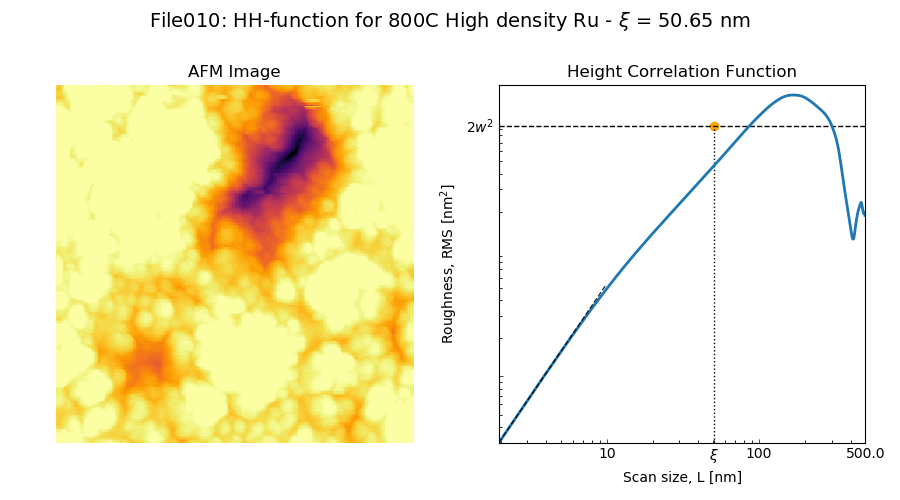

running file:Ru_H_800C_FLAT.010.txt, quadrant 1
256
0.8626178668836969


<IPython.core.display.Javascript object>


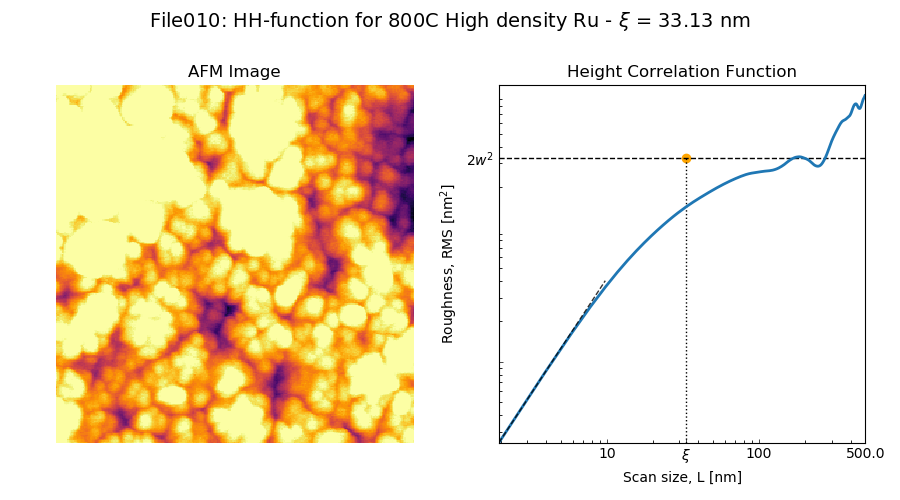

running file:Ru_H_800C_FLAT.010.txt, quadrant 2
256
0.8560142559104094


<IPython.core.display.Javascript object>


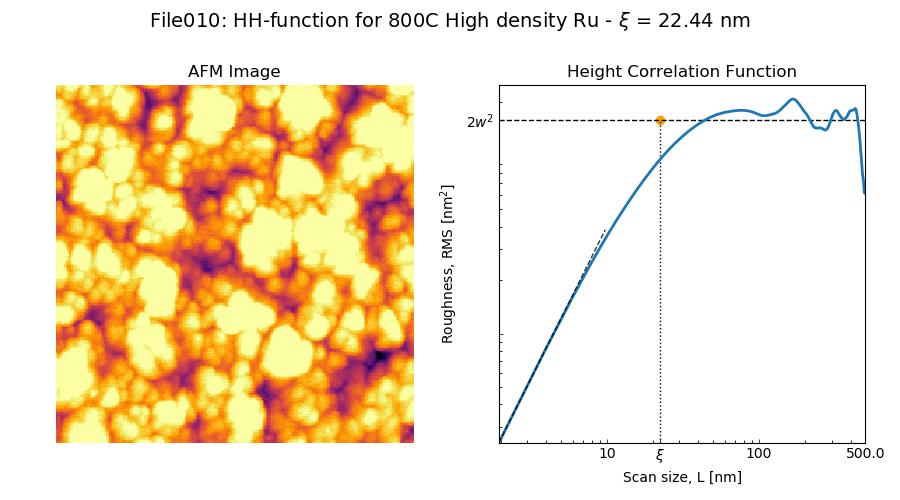

running file:Ru_H_800C_FLAT.010.txt, quadrant 3
256
0.8532149181798678


<IPython.core.display.Javascript object>


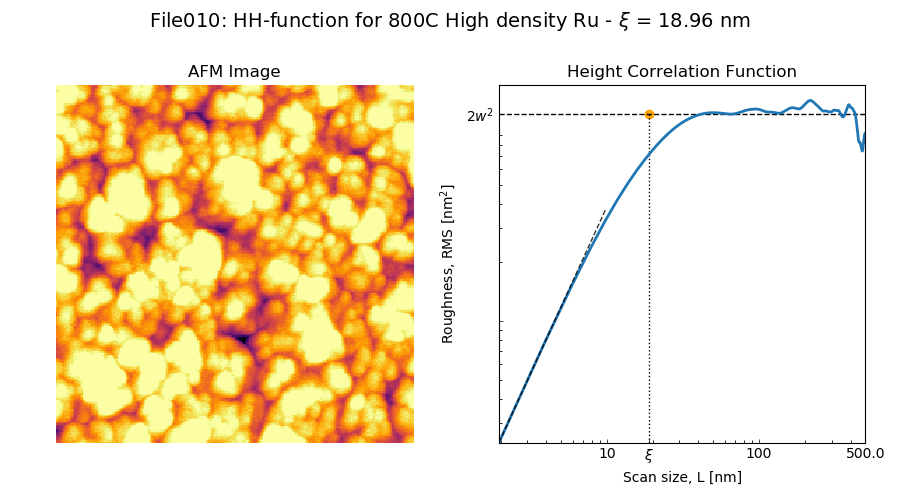

In [20]:
plotting = True
data = dict.fromkeys(filess)

for i,file in enumerate(filess[:]):
    
    if '*' in file:
        continue   
    if 'Ru_S_'in file:
        continue
    if 'Si' in file:
        continue
    if 'um' in file:
        continue   
    if '_H_' in file:
        density = 'High'
        if '800C' in file:
            temperature = '800C'
        else:
            continue
            temperature = temperature = file[5:9]        
    if '_L_' in file:
        continue
        density = 'Low'
        if 'asdep' in file:
            temperature = 'as-deposited'
        else:
            temperature = temperature = file[5:9]          
    if '_LH_' in file:
        continue
        density = 'Low-High'
        if 'asdep' in file:
            temperature = 'as-deposited'
        else:
            temperature = temperature = file[6:10]
            
    data[file] = {}
    
    filesize = os.path.getsize(file)     #to differentiate between 512x512 px or 1024x1024 px img
    Pix_width = int(np.sqrt(filesize/32))
    Pix_height = Pix_width
    
    data[file]['img'] = np.genfromtxt(file, skip_header=1).reshape((Pix_width,Pix_height))
    
    if Pix_width == 1024:
        print(f"Resampling file: {file}")
        data[file]['orig'] = data[file]['img']
        # overwrites the original data with the downsampled one
        # use cv2.INTER_LINEAR because it matches the histogram best
        data[file]['img'] = cv2.resize(data[file]['img'], dsize=(512,512),interpolation=cv2.INTER_LINEAR)
        
    N_Pixel = data[file]['img'].shape[1] 
    ScanSize = ScanSize_dict[file]                      # nm
    StepSize = ScanSize/N_Pixel                         # nm/px   
    
    Xdelta = np.linspace(StepSize, ScanSize, num=N_Pixel)
    
    rows, cols = data[file]['img'].shape
    midrows = rows // 2
    midcols = cols // 2
    
    quadrant1 = data[file]['img'][:midrows ,:midcols]
    quadrant2 = data[file]['img'][:midrows , midcols:]
    quadrant3 = data[file]['img'][ midrows:,:midcols]
    quadrant4 = data[file]['img'][ midrows:, midcols:]
    
    quadrants = [quadrant1, quadrant2, quadrant3, quadrant4]
    
    for j,quad in enumerate(quadrants):
        
        print(f'running file:{file}, quadrant {j}')
        
        # ***    Calculate theoretical asymptotic value of the Height difference correlation: 2w^2   ***

        N_Pixel = quad.shape[1] 
        print(N_Pixel)
        ScanSize = ScanSize_dict[file]/2                        # nm
        StepSize = ScanSize/N_Pixel                         # nm/px   
#         Xdelta = np.arange(N_Pixel)*StepSize               # Switching from pixels to step size in nm

        Xdelta = np.linspace(StepSize, ScanSize, num=N_Pixel)
        # Should be close to 0 when you have flattened out the image, so it is omittable
        AvgHeight = np.mean(quad)                            
        if False: print(f'AvgHeight = {AvgHeight}')        
        HeightSq = (quad-AvgHeight)**2                        
        if False: print(f'HeightSq shape = {HeightSq.shape}') #  (should be 512x512)
        RMS_sq = np.mean(HeightSq)               #   RMS^2 = w^2 - also called Interface Width
        if False: print(f'RMS squared = {RMS_sq}')            #  (should be a scalar)
        RMS = np.sqrt(RMS_sq)


        #error on the measurements:
    #     error_sq = np.sort(sum((np.sqrt(HeightSq) - RMS)**2)/(len(HeightSq)-1))

        # ***    Calculate Height-Height correlation function:   ***

        HHcorr = np.zeros(N_Pixel, dtype='float')
        autocorr = np.zeros(N_Pixel, dtype='float')

        for px_dist in range(0, N_Pixel):
            shifted_data = quad[:,px_dist+1:].astype(float)
            data_section = quad[:,:-px_dist-1].astype(float)
            if False:
                print(f'shifted data= {shifted_data.shape}')
                print(f'sectioned data= {data_section.shape}')
            difference = (data_section-shifted_data)**2
            product = (data_section*shifted_data)
            HHcorr[px_dist] = np.mean(difference)
            autocorr[px_dist]= 2*np.mean(product)

        # ***    Fit the data:   ***

        # consider the following number of pixels for the fit:
    #     CutoffPointPLaw = int(np.argwhere(HHcorr>=2*RMS_sq)[0])
        CutoffPointPLaw = int(np.argwhere(Xdelta>=10)[0])


        a0=0
        # weights for the fit, used for Method 1
        y_err1 = 1/(np.arange(1,CutoffPointPLaw+1))**2
        # For this Method, we define:
        y_err2 = np.sqrt(HHcorr[:CutoffPointPLaw])
        y_err3 = np.arange(a0,CutoffPointPLaw+a0)**2
        weights = np.exp(y_err3)


        # ***    Model for describing power law (on log scale):

        Model = lambda x, a, alpha: a*x**(2*alpha)


        # ***    Fit data using Model

        popt, pcov = curve_fit(Model, Xdelta[a0:CutoffPointPLaw+a0], HHcorr[a0:CutoffPointPLaw+a0], 
                               sigma = weights)


        # ***    Extracting the correlation length   ***

        #*popt= a,alpha
        a = popt[0]                                         # primo parametro dipendente
        alpha = popt[1]                                     # secondo paramtero dipendente
        print(alpha)
        
        # Equating a*(x**alpha)= 2*RMS_sq you extract x, the correlation length
        CorrLength= (1/a *(2*RMS_sq))**(1/(2*alpha))
        
        #For all the beautiful colors go to   http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=4
        #                                   &  https://www.quackit.com/css/css_color_codes.cfm

        # For axis settings:                 https://matplotlib.org/3.1.0/api/axes_api.html#axis-scales

        if plotting:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (9,5))
            ax = np.ravel(ax)

            AFM = ax[0].imshow(quad, cmap = 'inferno', vmax=1.8)
            ax[0].axis('off')
            ax[0].set_title(f"AFM Image")
        #     fig.colorbar(AFM, ax=ax[0])

            ax[1].loglog(Xdelta, HHcorr, label = 'HH corr', linewidth = 2, alpha=1)
                    #and its errors:
                    #plt.errorbar(Xdelta, HHcorr, yerr=e, fmt=".")

            # plot the fit
            ax[1].loglog(Xdelta[:CutoffPointPLaw], 
                         Model(Xdelta[:CutoffPointPLaw],*popt), 
                         label = 'Fit', 
                         linewidth = 1, 
                         linestyle='dashed', 
                         alpha = 0.8, color ='k')

            # show correlation length 
            ax[1].scatter(CorrLength, 2*RMS_sq, marker='o', color='orange')
            ax[1].vlines(CorrLength,HHcorr[0],2*RMS_sq, linestyle="dotted", linewidth=1)
            ax[1].hlines(2*RMS_sq, Xdelta[0], Xdelta[N_Pixel-2], linestyle="dashed",linewidth=1)

            # plt.legend()
            ax[1].tick_params(direction='in', length=3, width=0.5, colors='k')
            ax[1].set(xticks=(1,10,CorrLength,100, ScanSize))
            ax[1].set(xticklabels=(0,10,'$\\xi $',100,ScanSize))
            ax[1].set(yticks=(1,2*RMS_sq))
            ax[1].set_yticklabels(('','$2w^2$'))
            ax[1].tick_params(axis='x', which='minor', direction ='in', bottom=True)
            ax[1].tick_params(axis='y', which='minor', direction ='in',labelleft=False)


            ax[1].set(ylabel='Roughness, RMS [nm$^2$]')
            ax[1].set(xlabel='Scan size, L [nm]')
            ax[1].set_title(f"Height Correlation Function")

            ax[1].set_xlim(Xdelta[0], ScanSize)
            ax[1].set_ylim(HHcorr[0], 1.2*max(HHcorr))

            fig.tight_layout()

            sup_title = f"File{file[-7:-4]}: HH-function for {temperature} {density} density Ru - $\\xi $ = {CorrLength:.4} nm"
            fig.suptitle(sup_title, fontsize=14)
            fig.subplots_adjust(top=0.83)

            fname = f"HH function for {temperature} {density} density Ru - {file[-7:-4]}_{j}"
#             fig.savefig(f'{fname}.png', dpi=600)
#             fig.savefig(f'{fname}.svg', dpi=600)



In [ ]:
for i,file in enumerate(filess[:]):

    rows, cols = data[file]['img'].shape
    midrows = rows // 2
    midcols = cols // 2
    quadrant1 = data[file]['img'][:midrows ,:midcols]
    quadrant2 = data[file]['img'][:midrows , midcols:]
    quadrant3 = data[file]['img'][ midrows:,:midcols]
    quadrant4 = data[file]['img'][ midrows:, midcols:]
    
    quadrants = [quadrant1, quadrant2, quadrant3, quadrant4]
    
    for j,quad in enumerate(quadrants):
        
        print(f'running file:{file}, quadrant {j}')
        
        # ***    Calculate theoretical asymptotic value of the Height difference correlation: 2w^2   ***

        ScanSize = 250                       # nm
        N_Pixel = quad.shape[1] 
        Xdelta = np.linspace(StepSize, ScanSize, num=N_Pixel)

        AvgHeight = np.mean(quad)                            # Should be close to 0 when you have flattened out the image, so it is omittable
        if False: print(f'AvgHeight = {AvgHeight}')        
        HeightSq = (quad-AvgHeight)**2                        
        if False: print(f'HeightSq shape = {HeightSq.shape}') #  (should be 512x512)
        RMS_sq = np.mean(HeightSq)               #   RMS^2 = w^2 - also called Interface Width
        if False: print(f'RMS squared = {RMS_sq}')            #  (should be a scalar)
        RMS = np.sqrt(RMS_sq)


        #error on the measurements:
    #     error_sq = np.sort(sum((np.sqrt(HeightSq) - RMS)**2)/(len(HeightSq)-1))

        # ***    Calculate Height-Height correlation function:   ***

        HHcorr = np.zeros(N_Pixel, dtype='float')
        autocorr = np.zeros(N_Pixel, dtype='float')

        for px_dist in range(0, N_Pixel):
            shifted_data = quad[:,px_dist+1:].astype(float)
            data_section = quad[:,:-px_dist-1].astype(float)
            if False:
                print(f'shifted data= {shifted_data.shape}')
                print(f'sectioned data= {data_section.shape}')
            difference = (data_section-shifted_data)**2
            product = (data_section*shifted_data)
            HHcorr[px_dist] = np.mean(difference)
            autocorr[px_dist]= 2*np.mean(product)
        
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (9,5))
        ax = np.ravel(ax)
        
        AFM = ax[0].imshow(quad, cmap = 'inferno', vmax=1.8)
        ax[0].axis('off')
        ax[0].set_title(f"AFM Image")
    #     fig.colorbar(AFM, ax=ax[0])

        ax[1].semilogx(Xdelta, autocorr, label = 'Auto-corr', linewidth = 2, alpha=1)
                #and its errors:
                #plt.errorbar(Xdelta, HHcorr, yerr=e, fmt=".")
                
        fig.tight_layout()
